In [2]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import TextVectorization
from sklearn.metrics import classification_report, confusion_matrix
from logging import getLogger
import seaborn as sns

from src.models.utils import callbacks
from src.preprocessing.nlp import bucketing, regex_preprocess, build_vocabulary
from src.projects.ag_news.architecture import CnnGRU, GRUNet

Logging and constants

In [3]:
_log = getLogger()
model_save_fp = Path(os.getcwd()) / Path('trained_models') / Path('ag_news')

Loading a Tensorflow dataset and splitting train into train and validation

In [4]:
datasets, info = tfds.load("ag_news_subset", as_supervised=True, with_info=True)
TRAIN_SIZE = int(120000 * 0.8)
train_dataset = datasets['train'].take(TRAIN_SIZE)
validation_dataset = datasets['train'].skip(TRAIN_SIZE)
test_dataset = datasets['test']

Metal device set to: Apple M1 Max

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2022-12-02 14:06:37.096041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-02 14:06:37.096195: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Preprocessing text data

In [5]:
train_dataset = train_dataset.map(lambda x, y: (regex_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(lambda x, y: (regex_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)

Since we use variable sequence lengths, we will bucket similarly sized sequences together and pad them accordingly. We need to also ensure that within each training batch, the sequence lengths is always the same. Hence sequence lengths will vary across batches, but not within the same batch.

In [6]:
batch_size = 32
bucket_boundaries = [(0, 20), (20, 30), (30, 40), (40, 60), (60, 90), (90, 120)]
train_dataset = bucketing(
    dataset=train_dataset, 
    bucket_boundaries=bucket_boundaries, 
    batch_size=batch_size, 
    drop_remainder=True
)
validation_dataset = bucketing(
    dataset=validation_dataset, 
    bucket_boundaries=bucket_boundaries, 
    batch_size=batch_size, 
    drop_remainder=True
)

We can now create a vocabulary and adapt the tf.TextVectorization layer on it. The layer will then be passed to the model for both inference and training.

In [7]:
train_text_ds = train_dataset.map(lambda seq, lab: seq, num_parallel_calls=tf.data.AUTOTUNE)
flattened_x_train_ds = train_text_ds.flat_map(tf.data.Dataset.from_tensor_slices)
vocab_size = 20000
vect_layer = TextVectorization(
    max_tokens=vocab_size,
    standardize=None,
    split=None,
    output_mode='int',
    output_sequence_length=None,
)
vect_layer.adapt(flattened_x_train_ds)

2022-12-02 14:06:37.670044: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-02 14:06:37.763438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-02 14:06:44.623677: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-12-02 14:07:15.566817: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have 

We will now create a model that combines 1D Convolutional layera with a GRU layer. The rationale behind is to be able to feed longer sequences to the RNN, while mitigating the risk of exploding/vanishing gradients, since some of the input sequences can be fairly long (up to 120 timesteps).

Since the Conv1D applies a stride of 2, we effectively cut by half the length of each time sequence before it hits the GRU layer.

The output layer is a Dense layer with a softmax activation function (since we have 4 labels in total to predict)

In [8]:
train_dataset = train_dataset.shuffle(2000, reshuffle_each_iteration=True).repeat().prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.repeat().prefetch(tf.data.AUTOTUNE)

We can now start training. Both the training and validation datasets will repeat indefinitely, so we have to specify how many steps define an epoch

In [9]:
name = 'CnnGRU'
artifacts_path = model_save_fp / Path(name)
model = CnnGRU(name=name, filepath=artifacts_path)
model = model.connect_layers(vocab_size=vocab_size, vect_layer=vect_layer)
epochs = 30
model.fit(
    x=train_dataset, 
    validation_data=validation_dataset, 
    epochs=epochs, 
    callbacks=callbacks(), 
    steps_per_epoch=3500, 
    validation_steps=3500
)
model.save(artifacts_path)
_log.info(f"Saved {model.name} in folder {artifacts_path}")

Epoch 1/30


2022-12-01 15:38:32.012992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 15:38:36.157881: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-12-01 15:38:40.414227: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instea

 533/3500 [===>..........................] - ETA: 1:39 - loss: 0.7811 - accuracy: 0.6731

2022-12-01 15:39:01.816925: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 923/3500 [======>.......................] - ETA: 1:27 - loss: 0.6507 - accuracy: 0.7444

2022-12-01 15:39:15.262180: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 989/3500 [=======>......................] - ETA: 1:30 - loss: 0.6377 - accuracy: 0.7518

2022-12-01 15:39:19.983016: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 996/3500 [=======>......................] - ETA: 1:40 - loss: 0.6358 - accuracy: 0.7526

2022-12-01 15:39:24.101831: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1177/3500 [=========>....................] - ETA: 1:32 - loss: 0.6028 - accuracy: 0.7697

2022-12-01 15:39:30.928941: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2228/3500 [==================>...........] - ETA: 46s - loss: 0.5008 - accuracy: 0.8190

2022-12-01 15:40:05.574698: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3500/3500 [==============================] - ETA: 0s - loss: 0.4298 - accuracy: 0.8486

2022-12-01 15:40:45.656445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 15:40:47.189467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - 190s 50ms/step - loss: 0.4298 - accuracy: 0.8486 - val_loss: 0.3226 - val_accuracy: 0.8927 - lr: 0.0010
Epoch 2/30
3500/3500 [==============================] - 173s 49ms/step - loss: 0.2355 - accuracy: 0.9226 - val_loss: 0.3564 - val_accuracy: 0.8905 - lr: 0.0010
Epoch 3/30
3500/3500 [==============================] - 170s 49ms/step - loss: 0.1563 - accuracy: 0.9491 - val_loss: 0.3963 - val_accuracy: 0.8884 - lr: 0.0010
Epoch 4/30
3500/3500 [==============================] - 163s 46ms/step - loss: 0.0999 - accuracy: 0.9680 - val_loss: 0.4765 - val_accuracy: 0.8803 - lr: 0.0010
Epoch 5/30
3500/3500 [==============================] - 161s 46ms/step - loss: 0.0705 - accuracy: 0.9773 - val_loss: 0.5115 - val_accuracy: 0.8807 - lr: 0.0010
Epoch 6/30
3500/3500 [==============================] - 159s 45ms/step - loss: 0.0591 - accuracy: 0.9810 - val_loss: 0.5426 - val_accuracy: 0.8839 - lr: 0.0010
Epoch 7/30
3500/3500 [=============================

INFO:tensorflow:Assets written to: /Users/gianrond/git/deeplearning/trained_models/ag_news/CnnGRU/assets


INFO:tensorflow:Assets written to: /Users/gianrond/git/deeplearning/trained_models/ag_news/CnnGRU/assets


In [8]:
name = 'GRUNet'
artifacts_path = model_save_fp / Path(name)
model = GRUNet(name=name, filepath=artifacts_path)
model = model.connect_layers(vocab_size=vocab_size, vect_layer=vect_layer)
epochs = 30
model.fit(
    x=train_dataset, 
    validation_data=validation_dataset, 
    epochs=epochs, 
    callbacks=callbacks(), 
    steps_per_epoch=3500, 
    validation_steps=3500
)
model.save(artifacts_path)
_log.info(f"Saved {model.name} in folder {artifacts_path}")

Model: "GRUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, None)        0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          (None, None, 128)    2560128     ['text_vectorization[0][0]']     
                                                                                                  
 lambda (Lambda)                (None, None)         0           ['input_1[0][0]']           

2022-12-01 17:17:14.443013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 17:17:19.340182: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2022-12-01 17:17:23.872906: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instea

 531/3500 [===>..........................] - ETA: 2:23 - loss: 0.7465 - accuracy: 0.6774

2022-12-01 17:17:52.866170: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 924/3500 [======>.......................] - ETA: 2:07 - loss: 0.6152 - accuracy: 0.7540

2022-12-01 17:18:12.886067: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 989/3500 [=======>......................] - ETA: 2:08 - loss: 0.6043 - accuracy: 0.7608

2022-12-01 17:18:17.972755: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


 996/3500 [=======>......................] - ETA: 2:17 - loss: 0.6032 - accuracy: 0.7615

2022-12-01 17:18:22.080496: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1176/3500 [=========>....................] - ETA: 2:09 - loss: 0.5776 - accuracy: 0.7772

2022-12-01 17:18:32.649371: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


2229/3500 [==================>...........] - ETA: 1:08 - loss: 0.5235 - accuracy: 0.8124

2022-12-01 17:19:26.608918: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


3499/3500 [============================>.] - ETA: 0s - loss: 0.4720 - accuracy: 0.8362

2022-12-01 17:20:27.353967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 17:20:29.047351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 17:20:29.214588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - 282s 76ms/step - loss: 0.4719 - accuracy: 0.8362 - val_loss: 0.3558 - val_accuracy: 0.8846 - lr: 0.0010
Epoch 2/30
3500/3500 [==============================] - 270s 77ms/step - loss: 0.2986 - accuracy: 0.9036 - val_loss: 0.3097 - val_accuracy: 0.8983 - lr: 0.0010
Epoch 3/30
3500/3500 [==============================] - 264s 76ms/step - loss: 0.2403 - accuracy: 0.9223 - val_loss: 0.3032 - val_accuracy: 0.8992 - lr: 0.0010
Epoch 4/30
3500/3500 [==============================] - 260s 74ms/step - loss: 0.2080 - accuracy: 0.9322 - val_loss: 0.3068 - val_accuracy: 0.8986 - lr: 0.0010
Epoch 5/30
3500/3500 [==============================] - 255s 73ms/step - loss: 0.1868 - accuracy: 0.9377 - val_loss: 0.3202 - val_accuracy: 0.8949 - lr: 0.0010
Epoch 6/30
3500/3500 [==============================] - 252s 72ms/step - loss: 0.1681 - accuracy: 0.9427 - val_loss: 0.3432 - val_accuracy: 0.8939 - lr: 0.0010
Epoch 7/30
3500/3500 [=============================

INFO:tensorflow:Assets written to: /Users/gianrond/git/deeplearning/trained_models/ag_news/GRUNet/assets


INFO:tensorflow:Assets written to: /Users/gianrond/git/deeplearning/trained_models/ag_news/GRUNet/assets


After training is completed, we can load the model and use it for inference on the test dataset

In [10]:
model_paths = {
    'CnnGRU' : model_save_fp / Path('CnnGRU'),
    'GRUNet': model_save_fp / Path('GRUNet'),
}

loaded_models = {}
for model_name, model_path in model_paths.items():
    loaded_models[model_name] = tf.keras.models.load_model(model_path)


2022-12-01 16:21:39.425262: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-01 16:21:39.477185: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-01 16:21:39.483976: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-01 16:21:39.610277: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond' has 4 outputs but the _output_shapes attribute specifies shapes for 46 outputs. Output shapes may be inaccurate.
2022-12-01 16:21:40.019645: W tensorflow/core/common_runtime/graph_constructor.cc:805] Node 'cond/while' has 13 outputs but the _output_sh

Before we can use it on the test dataset, we need to apply some preprocessing. We can use a batch size of 1 to deal with sequences that have different lengths. This has a negative impact on performance, but it allows us to make predictions for each element in the test data.

Alternatively, we could batch sequences together with the bucketing function and pass the bucketed Dataset to predict, which would result in much faster prediction times, but sequences that exceed the higher bound timestep limit would be left out.

In [11]:
test_dataset = test_dataset.map(lambda x, y: (regex_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
bucket_boundaries = [(0, 20), (20, 30), (30, 40), (40, 60), (60, 90), (90, 120)]
test_dataset = bucketing(
    dataset=test_dataset, 
    bucket_boundaries=bucket_boundaries, 
    batch_size=32, 
    drop_remainder=True
)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

Loading different trained models and comparing their performance. We use accuracy as metric.

In [12]:
accuracies = {}
for model_name, model in loaded_models.items():
    accuracies[model_name] = model.evaluate(test_dataset)
print(accuracies)

2022-12-01 16:21:41.237145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 16:21:41.433066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


234/234 [==============================] - 5s 16ms/step - loss: 0.3295 - accuracy: 0.8933


In [13]:
pred_dataset = tf.data.Dataset.zip((test_dataset.map(lambda x, y: x, num_parallel_calls=tf.data.AUTOTUNE), ))
y_true = np.array(list(test_dataset.map(lambda x, y: y, num_parallel_calls=tf.data.AUTOTUNE).unbatch().as_numpy_iterator()))

y_pred = model.predict(pred_dataset)
y_pred = np.argmax(y_pred, axis=1)

2022-12-01 16:21:47.756564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-01 16:21:47.932782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


234/234 [==============================] - 4s 14ms/step


Evaluating the accuracy of the predictions on test data

In [14]:
cr = classification_report(y_true, y_pred)
print(cr)
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1883
           1       0.94      0.96      0.95      1882
           2       0.84      0.89      0.86      1873
           3       0.89      0.83      0.86      1850

    accuracy                           0.89      7488
   macro avg       0.89      0.89      0.89      7488
weighted avg       0.89      0.89      0.89      7488



[Text(0.5, 23.52222222222222, 'Predicted class'),
 Text(50.722222222222214, 0.5, 'True class')]

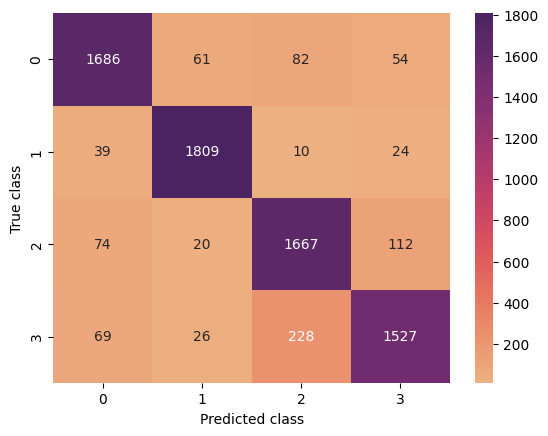

In [15]:
heatmap = sns.heatmap(cm, annot=True, fmt='g', cmap='flare')
heatmap.set(xlabel='Predicted class', ylabel='True class')